# anesthetic plot gallery
 This functions as both some examples of plots that can be produced, and a tutorial.
 Any difficulties/issues/requests should be posted as a [GitHub issue](https://github.com/williamjameshandley/anesthetic/issues)

## Download example data
 Download some example data from github (or alternatively use your own chains files)

 This downloads the PLA chains for the planck baseline cosmology,
 and the equivalent nested sampling chains:

In [1]:
import requests
import tarfile

for filename in ["plikHM_TTTEEE_lowl_lowE_lensing.tar.gz","plikHM_TTTEEE_lowl_lowE_lensing_NS.tar.gz"]:
    github_url = "https://github.com/williamjameshandley/cosmo_example/raw/master/"
    url = github_url + filename
    open(filename, 'wb').write(requests.get(url).content)
    tarfile.open(filename).extractall()

## Marginalised posterior plotting
 Import anesthetic and load the MCMC samples:

In [2]:
import matplotlib.pyplot as plt
from anesthetic import read_chains, make_2d_axes
mcmc_root = 'plikHM_TTTEEE_lowl_lowE_lensing/base_plikHM_TTTEEE_lowl_lowE_lensing'
mcmc = read_chains(mcmc_root)

We have plotting tools for 1D plots ...

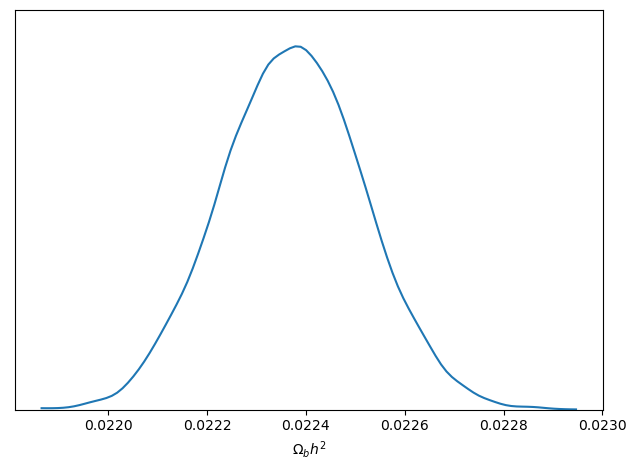

In [3]:
mcmc.plot_1d('omegabh2') ;

... multiple 1D plots ...

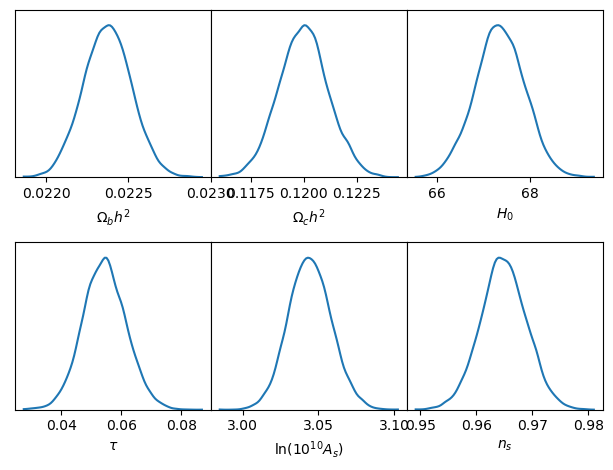

In [4]:
mcmc.plot_1d(['omegabh2','omegach2','H0','tau','logA','ns']);

... triangle plots ...

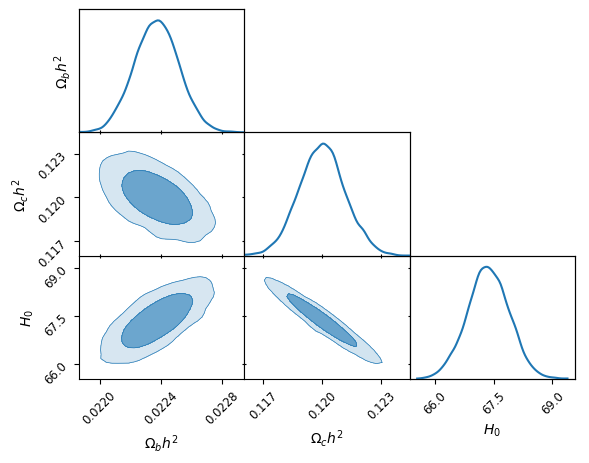

In [5]:
mcmc.plot_2d(['omegabh2','omegach2','H0'], kind={'lower':'kde_2d','diagonal':'kde_1d'});

... triangle plots (with the equivalent scatter plot filling up the left hand side) ...

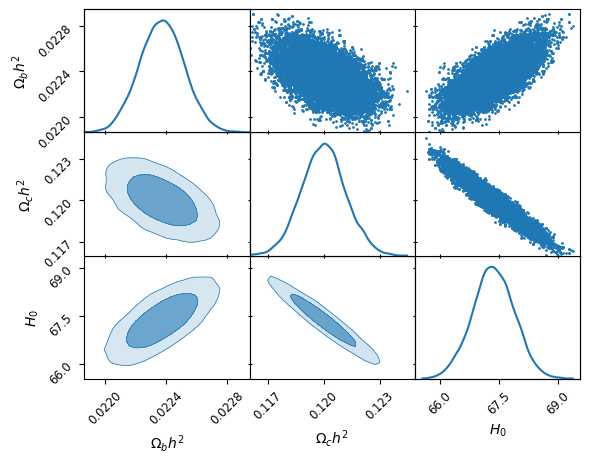

In [6]:
mcmc.plot_2d(['omegabh2','omegach2','H0']);

... and rectangle plots.

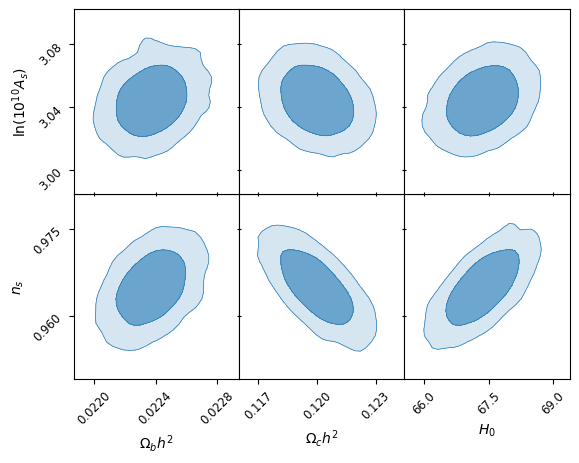

In [7]:
mcmc.plot_2d([['omegabh2','omegach2','H0'], ['logA', 'ns']]);

Rectangle plots are pretty flexible with what they can do:

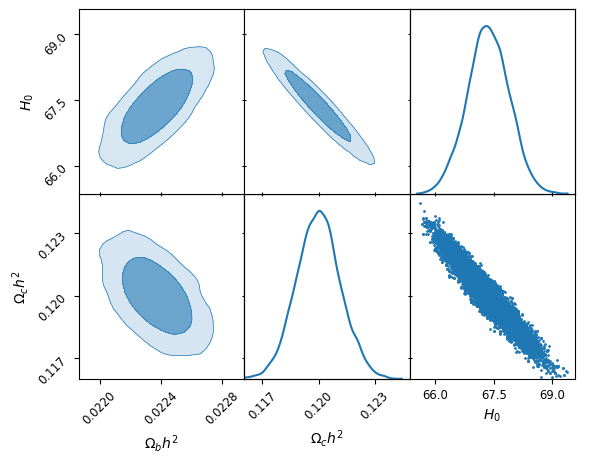

In [8]:
mcmc.plot_2d([['omegabh2','omegach2','H0'], ['H0','omegach2']]);

## Changing the appearance
 
 Anesthetic tries to follow matplotlib conventions as much as possible, so 
 most changes to the appearance should be relatively straight forward. 
 Here are some examples:
 
 * figure size:

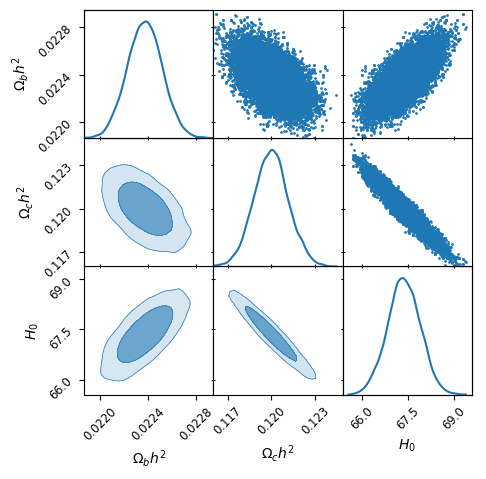

In [9]:
fig = plt.figure(figsize=(5, 5))
fig, axes = make_2d_axes(['omegabh2', 'omegach2', 'H0'], fig=fig)
mcmc.plot_2d(axes);

* legends:

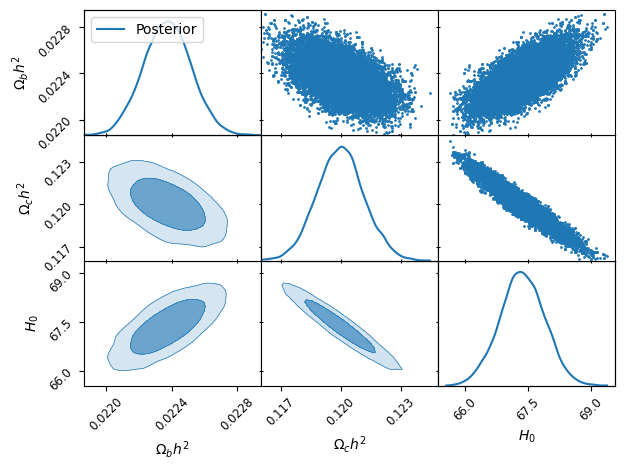

In [10]:
fig, axes = make_2d_axes(['omegabh2', 'omegach2', 'H0'])
mcmc.plot_2d(axes, label='Posterior');
axes.iloc[0, 0].legend(loc='upper left');
fig.tight_layout()

* unfilled contours  &  modifying individual axes:

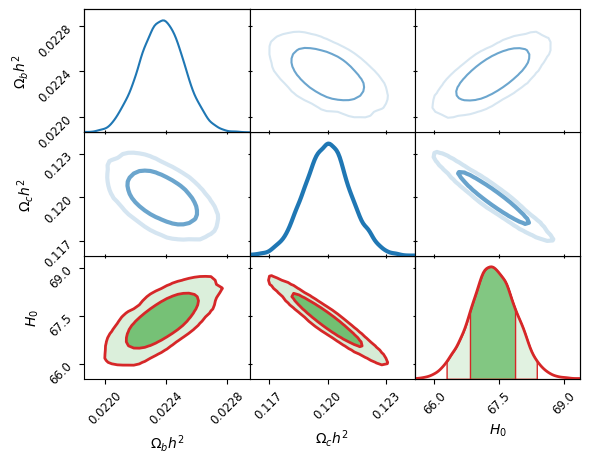

In [11]:
fig, axes = make_2d_axes(['omegabh2', 'omegach2', 'H0'])
mcmc.plot_2d(axes.iloc[0:1, :], kind=dict(upper='kde_2d', lower='kde_2d', diagonal='kde_1d'), fc=None);
mcmc.plot_2d(axes.iloc[1:2, :], kind=dict(upper='kde_2d', lower='kde_2d', diagonal='kde_1d'), fc=None, cmap=plt.cm.Oranges, lw=3);
mcmc.plot_2d(axes.iloc[2:3, :], kind=dict(upper='kde_2d', lower='kde_2d', diagonal='kde_1d'), fc='C2', ec='C3', c='C4', lw=2);

## Defining new parameters

 You can see that samples are stored as a pandas array

In [12]:
mcmc[:6]

,,omegabh2,omegach2,theta,tau,logA,ns,calPlanck,acib217,xi,asz143,...,f2000_x,f2000_217,chi2_lensing,chi2_simall,chi2_lowl,chi2_plik,chi2_prior,chi2_CMB,logL,chain
,labels,$\Omega_b h^2$,$\Omega_c h^2$,$100\theta_{MC}$,$\tau$,${\rm{ln}}(10^{10} A_s)$,$n_s$,$y_{\rm cal}$,$A^{CIB}_{217}$,$\xi^{tSZ-CIB}$,$A^{tSZ}_{143}$,...,$f_{2000}^{143\times217}$,$f_{2000}^{217}$,$\chi^2_{\rm lensing}$,$\chi^2_{\rm simall}$,$\chi^2_{\rm lowl}$,$\chi^2_{\rm plik}$,$\chi^2_{\rm prior}$,$\chi^2_{\rm CMB}$,$\ln\mathcal{L}$,$n_\mathrm{chain}$
,weights,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.022236,0.119022,1.040860,0.057732,3.044784,0.972823,0.999421,45.26123,0.220558,7.089804,...,29.72710,105.0097,9.080994,396.7567,21.86047,2363.208,4.604292,2790.906,-1397.755,1
1,1.0,0.022212,0.119042,1.040930,0.060019,3.050158,0.971052,0.999462,33.66526,0.663860,6.944407,...,29.55360,106.2465,8.902029,397.5068,22.26878,2361.344,13.781540,2790.022,-1401.902,1
2,2.0,0.022188,0.119034,1.040894,0.060375,3.050733,0.971215,0.999462,38.38740,0.630513,6.452556,...,30.64146,106.7611,8.909747,397.6345,22.23237,2356.451,4.580436,2785.227,-1394.904,1
3,1.0,0.022139,0.119490,1.041048,0.061047,3.053969,0.971959,1.000137,46.48444,0.216055,5.573888,...,31.17108,106.4796,9.093967,397.8919,22.09051,2364.513,4.199266,2793.589,-1398.894,1
4,1.0,0.022064,0.120595,1.040885,0.057995,3.048751,0.968957,0.999233,46.08949,0.406260,3.696362,...,31.05737,106.3372,9.498806,397.0563,22.55137,2365.853,6.752361,2794.959,-1400.856,1
5,1.0,0.022057,0.120610,1.040870,0.058543,3.049231,0.968699,0.999166,53.30974,0.010308,5.656808,...,30.60033,105.6100,9.479549,397.2521,22.57899,2364.413,11.676710,2793.723,-1402.700,1


Since it's a (weighted) pandas array, we compute things like the mean and variance 
 of samples

In [13]:
mcmc.mean()

            labels                  
omegabh2    $\Omega_b h^2$                 0.022373
omegach2    $\Omega_c h^2$                 0.119994
theta       $100\theta_{MC}$               1.040916
tau         $\tau$                         0.054369
logA        ${\rm{ln}}(10^{10} A_s)$       3.044422
                                           ...     
chi2_plik   $\chi^2_{\rm plik}$         2359.441690
chi2_prior  $\chi^2_{\rm prior}$          11.498672
chi2_CMB    $\chi^2_{\rm CMB}$          2789.192953
logL        $\ln\mathcal{L}$           -1400.345813
chain       $n_\mathrm{chain}$             2.496145
Length: 96, dtype: float64

We can define new parameters with relative ease.
 For example, the default cosmoMC setup does not include omegab, only omegabh2:

In [14]:
'omegab' in mcmc

False

However, this is pretty trivial to recompute:

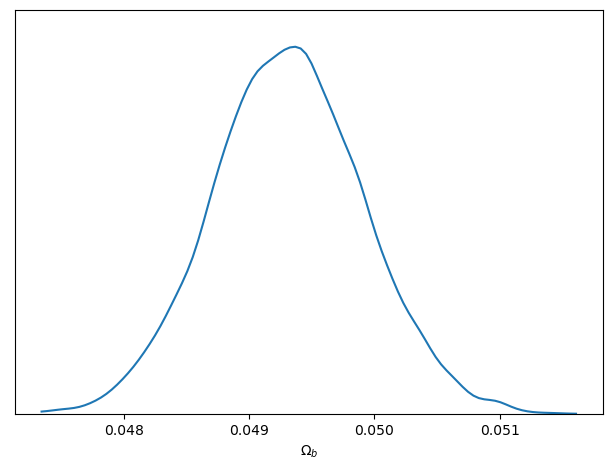

In [15]:
h = mcmc['H0']/100
mcmc['omegab'] = mcmc['omegabh2']/h**2
mcmc.set_label('omegab', '$\Omega_b$')
mcmc.plot_1d('omegab');

## Nested sampling plotting
 Anethestic really comes to the fore for nested sampling. We can do all of
 the above, and more with the power that NS chains provide

In [16]:
nested_root = 'plikHM_TTTEEE_lowl_lowE_lensing_NS/NS_plikHM_TTTEEE_lowl_lowE_lensing'
nested = read_chains(nested_root)

/home/will/code/anesthetic/anesthetic/samples.py:951: RuntimeWarning: 7 out of 60705 samples have logL <= logL_birth,
7 of which have logL == logL_birth.
This may just indicate numerical rounding errors at the peak of the likelihood, but further investigation of the chains files is recommended.
Dropping the invalid samples.
  warnings.warn("%i out of %i samples have logL <= logL_birth,"


We can infer the evidence, KL divergence and Bayesian model dimensionality:

In [17]:
ns_output = nested.stats(1000)

This is a set of ``MCMCSamples``, with columns yielding the log of the Bayesian evidence 
 (logZ), the Kullback-Leibler divergence (D) and the Bayesian model dimensionality (d).

In [18]:
ns_output[:6]

,logZ,D_KL,d_G,logL_P
labels,$\ln\mathcal{Z}$,$\mathcal{D}_\mathrm{KL}$,$d_\mathrm{G}$,$\langle\ln\mathcal{L}\rangle_\mathcal{P}$
samples,,,,
0,-12325.060953,39.008882,8.531861,-12286.052070
1,-12325.380669,39.091699,8.586281,-12286.288970
2,-12325.120724,39.087967,8.184286,-12286.032757
3,-12325.385906,39.471060,8.315213,-12285.914847
4,-12325.103187,38.986963,8.602075,-12286.116224
5,-12325.495618,39.361752,8.370674,-12286.133866


The evidence, KL divergence and Bayesian model dimensionality, with their corresponding errors, are:

In [19]:
for x in ['logZ', 'D_KL', 'd_G', 'logL_P']:
    print('%10s = %9.2f +/- %4.2f' % (ns_output.get_label(x), ns_output[x].mean(), ns_output[x].std()))

$\ln\mathcal{Z}$ = -12325.23 +/- 0.19
$\mathcal{D}_\mathrm{KL}$ =     39.17 +/- 0.19
$d_\mathrm{G}$ =      8.37 +/- 0.20
$\langle\ln\mathcal{L}\rangle_\mathcal{P}$ = -12286.06 +/- 0.09


Since ``ns_output`` is a set of ``MCMCSamples``, it may be plotted as usual. 
 Here we illustrate slightly more fine-grained control of the axes construction 
 (demanding three columns)

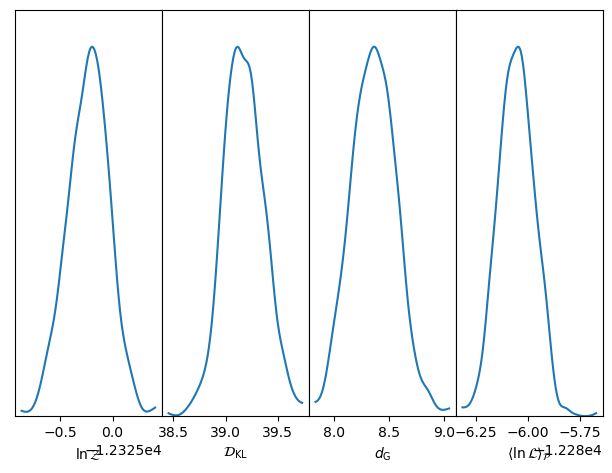

In [20]:
from anesthetic import make_1d_axes, MCMCSamples
fig, axes = make_1d_axes(['logZ', 'D_KL', 'd_G', 'logL_P'], ncol=4)
MCMCSamples(ns_output).plot_1d(axes);

We can also inspect the correlation between these inferences:

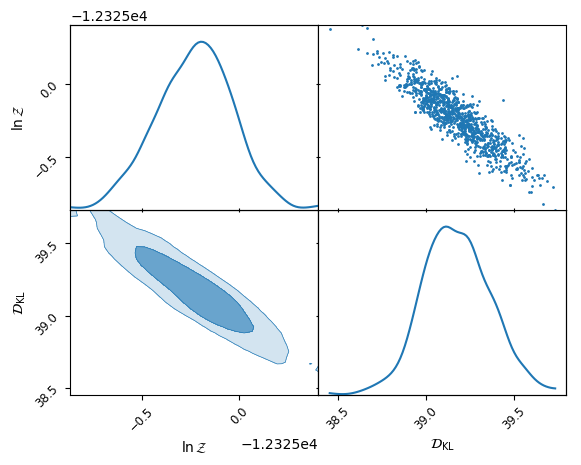

In [21]:
MCMCSamples(ns_output).plot_2d(['logZ','D_KL']);

Here is a comparison of the base and NS output

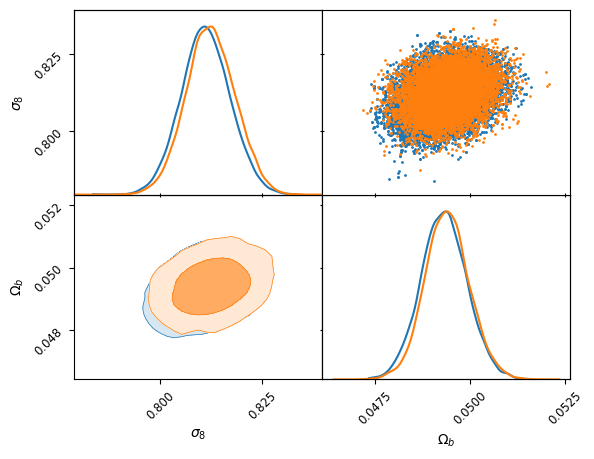

In [22]:
h = nested['H0']/100
nested['omegab'] = nested['omegabh2']/h**2
nested.set_label('omegab', '$\Omega_b$')

axes = mcmc.plot_2d(['sigma8','omegab'])
nested.plot_2d(axes=axes);

With nested samples, we can plot the prior (or any temperature), by
 passing beta=0. We also introduce here how to create figure legends."

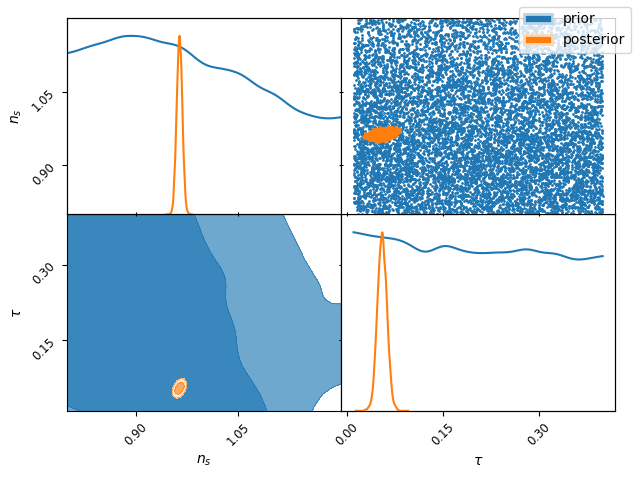

In [23]:
prior = nested.set_beta(0)
axes = prior.plot_2d(['ns','tau'], label='prior')
nested.plot_2d(axes=axes, label='posterior')
handles, labels = axes['ns']['tau'].get_legend_handles_labels()
fig = axes.loc['ns','tau'].figure
leg = fig.legend(handles, labels)
fig.tight_layout()

We can also set up an interactive plot, which allows us to replay a nested
 sampling run after the fact.

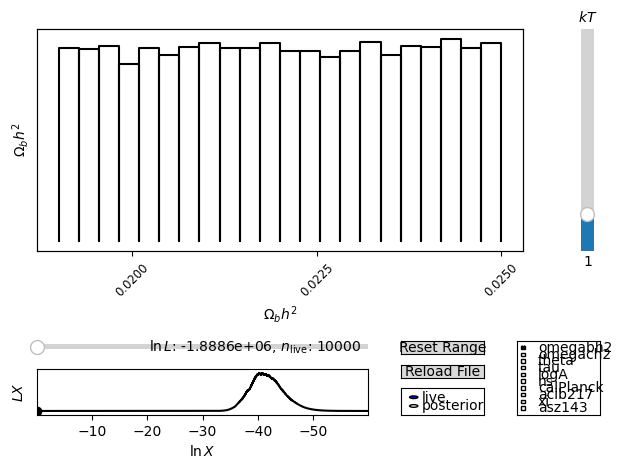

In [24]:
nested.gui()

There are also tools for converting to alternative formats, in case you have
 pipelines in other plotters:

In [25]:
from anesthetic.convert import to_getdist
getdist_samples = to_getdist(nested)

Removed no burn in
